# 4. Python data science modules

Now we've got a grasp on the fundamentals of Python, we're ready to use Python for data science.

Unlike some more math-oriented programming languages (like R or MATLAB), Python relies on external packages to provide most data science functionality.

The Python community has largely standardized on the following packages, all of which we'll be covering in this module, and will be using extensively for the rest of the course:

* numpy - math tools, plus working with 1D & 2D arrays
* pandas - working with tabular data
* matplotlib - making plots and visualizations




## Numpy

Numpy is a Python package for representing **array data**, and comes with a large library of tools and mathematical functions that operate efficiently on arrays, mostly through its `ndarray` class.

Numpy is by far the most popular Python package for data science, and is one of the [most-downloaded](https://pypistats.org/top) python packages overall. It's so useful and reliable, that most of the mathematical functionality of the other packages covered in this module (pandas, seaborn, matplotlib) is provided by numpy under the hood.

Because numpy is used a lot, it's convention to import it with the `np` abbreviation:

In [1]:
import numpy as np


### Why numpy?

A numpy array is similar to a Python list: they can both serve as containers for numbers.

In [2]:
python_list = [0, 2, 4, 6]
print(python_list)

[0, 2, 4, 6]


In [3]:
numpy_array = np.array([0, 2, 4, 6])
print(numpy_array)

[0 2 4 6]


So why use numpy instead of lists?

* Speed
    * Although numpy is a Python package, most of the functionality is written in fast C or Fortran code.
* Memory efficient
    * Numpy uses less memory to store numbers than Python, so you can work on larger datasets.
* Functionality
    * Numpy comes with a huge range of modules with fast and thoroughly-validated algorithms from interpolation to fourier transforms.
* Manipulation syntax
    * Numpy's syntax makes it clear and easy to perform common array operations, like slicing, filtering, and summarization.


But there are some usecases where lists make more sense

* Storing different kinds of data together
    * Numpy arrays are homogeneous, all the elements must be the same type
* Working with non-numerical data
    * Only some numpy functionality works with strings and other types



### Creating arrays

One way to create an array is from a Python sequence like a list using the `array()` function

In [4]:
days_per_month_list = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
days_per_month = np.array(days_per_month_list)
days_per_month

array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

Nesting lists will create higher dimensional arrays.

In [5]:
array_2d = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]])
array_2d

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])


As well as converting Python lists to arrays, numpy can create its own arrays!

You can create an array that's filled with a certain number of zeros

In [6]:
np.zeros(5)

array([0., 0., 0., 0., 0.])

or ones (we specify the number of rows, then the number of columns for a 2D array)

In [7]:
np.ones((2, 5))

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

Numpy has it's own version of the Python `range()` function:

In [8]:
np.arange(2, 9, 2)

array([2, 4, 6, 8])

and a related `linspace()` function to create an array with evenly-spaced elements.

In [9]:
np.linspace(0, 10, num=5)

array([ 0. ,  2.5,  5. ,  7.5, 10. ])

There's a whole `random` module that can create arrays from randomly sampling various distributions

In [10]:
np.random.uniform(low=0, high=10, size=(2, 5))

array([[1.96617498, 0.15494402, 1.44959164, 7.52110281, 6.02686026],
       [0.19261137, 7.50417988, 0.12948102, 6.33361253, 8.82702895]])

### Size and shape

We can use `len()` to get the length of a 1D array

In [11]:
len(days_per_month)

12

while the `.shape` attribute will give the length of each dimension (remember the 2D order? **rows then cols**!)

In [12]:
array_2d.shape

(3, 4)

### Array arithmetic

Arrays let you express mathematical equations without for loops. This makes your code much faster, plus numpy code tends to read more like a math formula than programming.

Operations with single numbers are applied to the whole array

In [13]:
weeks_per_month = days_per_month / 7
print(weeks_per_month)

[4.42857143 4.         4.42857143 4.28571429 4.42857143 4.28571429
 4.42857143 4.42857143 4.28571429 4.42857143 4.28571429 4.42857143]


whereas operations between arrays of the same size are applied element-wise

In [14]:
days_per_month + days_per_month

array([62, 56, 62, 60, 62, 60, 62, 62, 60, 62, 60, 62])

Comparing arrays results in an array of the same size with True/False values.

In [15]:
is_long_month = days_per_month >= 31
print(is_long_month)

[ True False  True False  True False  True  True False  True False  True]


To perform boolean logic, numpy uses `&` instead of `and`, and `|` instead of `or`.

In [16]:
is_q1_month = np.arange(12) < 3
is_long_q1_month = is_q1_month & is_long_month

print(is_long_q1_month)

[ True False  True False False False False False False False False False]



### Array slicing and indexing


Like a Python list, arrays can be sliced

In [17]:
days_per_month[0:3]

array([31, 28, 31])

and individual elements can be index out

In [18]:
print(days_per_month[1])

28


You index a 2D array using the same notation: first your row slicing, then a comma `,`, then your column slicing.

Here's our array as a reminder

In [19]:
array_2d

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])


For example the first element of the second row:

In [20]:
print(array_2d[1, 0])

5


or the top three values of the last column

In [21]:
print(array_2d[0:3, -1])

[ 4  8 12]


Note how our column has lost its "verticalness": once we've sliced it out, it's just a regular 1D array.

Assigning new values to an array uses the same slice syntax. A single value will be repeated to all elements:

In [22]:
array_2d[0, :] = 99
array_2d

array([[99, 99, 99, 99],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

while an equal-length sequence will be assigned elementwise

In [23]:
array_2d[:, 3] = [-1, -2, -3]
array_2d

array([[99, 99, 99, -1],
       [ 5,  6,  7, -2],
       [ 9, 10, 11, -3]])

If we make a slice then modify it, the original array is modified too!

In [24]:
array_2d_slice = array_2d[1:2, 2:3]
array_2d_slice[0] = -9999
array_2d

array([[   99,    99,    99,    -1],
       [    5,     6, -9999,    -2],
       [    9,    10,    11,    -3]])

To keep numpy's speedy performance, making a slice doesn't copy any data, just provides a "view" to the original array.

If we want to modify a subset of the data independently, we can use the copy method.

In [25]:
q1_months = days_per_month[:3]
q1_months_leap_year = q1_months.copy()
q1_months_leap_year[1] = 29
q1_months_leap_year

array([31, 29, 31])

### Data types

All values in a numpy array are converted to be the same type. By default, numpy will take an educated guess about what type we want, and we can see its choice with the `dtype` attribute

In [26]:
array_default = np.array([1, 2, 3])
array_default.dtype

dtype('int64')

We can override the dtype though

In [27]:
array_manual = np.array([1, 2, 3], dtype=np.float64)
array_manual.dtype

dtype('float64')

Other than ints and floats, the boolean dtype is frequently used in numpy

In [28]:
is_positive = array_2d > 0
is_positive.dtype

dtype('bool')

Arrays can store strings, though of course some numpy mathematical tools won't work

In [29]:
states = np.array(["Washington", "Oregon", "California"])
states.dtype

dtype('<U10')

The `U` in `<U10` stands for "Unicode string". The `<` and `10` characters represent internal numpy storage attributes ([endianess](https://stackoverflow.com/questions/24248756/python-numpy-data-io-how-to-save-data-by-different-dtype-for-each-column/24249116) and number of characters respectively).

An array can also store arbitrary python objects. Lets make an array containing a number as well as the `print()` function

In [30]:

# This is a terrible idea.
mixed = np.array([42, print])
mixed.dtype

dtype('O')

Numpy gives up and applies the `O` for "object" dtype (everything in Python is an object).

If you see this in the real world, it's usually a sign that you're number parsing has gone wrong! Otherwise, you may as well use a regular list.

### Boolean indexing

Here are some state names, with corresponding mean annual precipitation.



In [31]:
states = np.array(["Washington", "Oregon", "California"])
precip = np.array([38.67, 43.62, 22.97])

To pick out California we can use `==` to create a boolean array

In [32]:
states == "California"

array([False, False,  True])

Passing this boolean array as indexing to another array of the same length will slice out only the elements matching `True`

precip[states == "California"]

This is really powerful for working between corresponding arrays!

Negation can be done with `!=`

In [33]:
precip[states == "California"]

array([22.97])

or by using `~` to flip all the booleans in an array

In [34]:
~(states == "California")

array([ True,  True, False])

In [35]:
match = states == "California"
precip[~match]

array([38.67, 43.62])

We can also filter the other way

In [36]:
high_rainfall = precip > 30
states[high_rainfall]

array(['Washington', 'Oregon'], dtype='<U10')

### Mathematical functions

Numpy comes with a array versions of the functions in the builtin `math` module, and many more.

Many are element-wise transformations

In [37]:
nums = np.linspace(0, 100, 4)

print(nums)
print(np.floor(nums))  # Round down to next integer.

[  0.          33.33333333  66.66666667 100.        ]
[  0.  33.  66. 100.]


while others summarize

In [38]:
np.median(nums)

np.float64(50.0)

Here's a few of the more common numpy functions

* Element-wise
    * `sin`, `arcsine`, `deg2rad`: trigonometry
    * `round`, `floor`, `ceil`: rounding
    * `exp`, `log`, `log10`: logarithms
    * `clip`: limit the elements in an array


* Summarizing
    * `mean`, `median`, `mode`: averages
    * `std`, `var`: skew
    * `sum`, `prod`: sum/product of all elements
    * `percentile`, `quantile`: order


Because numpy is so foundational to scientific Python, if you can't find a common math algorithm in numpy, there's likely to be another package that provies the function with full support for numpy arrays. 

Good places to hunt for extended math functions include

* [scipy](https://docs.scipy.org/doc/scipy/reference/index.html) has many submodules including functions for interpolation, statistics, and linear algebra
* [statsmodels](https://www.statsmodels.org/stable/index.html) for summary statistics
* [pandas](https://pandas.pydata.org/) has functions for dealing with time series and strings



### NaNs


`NaN` stands for "Not a Number".


They can come from importing missing data

In [39]:
values = ["1", None, "3"]
np.array(values, dtype=np.float64)

array([ 1., nan,  3.])

or as the result of mathematical operations

In [40]:
np.arange(5) / np.arange(5)

/tmp/ipykernel_2572781/1888149002.py:1: RuntimeWarning: invalid value encountered in divide
  np.arange(5) / np.arange(5)


array([nan,  1.,  1.,  1.,  1.])

but most commonly come from other NaNs!

**NaNs propagate**. The result of an operation where any of the inputs is NaN, usually results in a NaN output, which can spread to your entire dataset!

In [41]:
array_2d = np.array([[np.nan, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]])
array_2d

array([[nan,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12.]])

In [42]:
array_2d_normalized = array_2d / np.max(array_2d)
array_2d_normalized

array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]])

There are a few things we can do to manage and embrace NaN values.

First, if you can't discard invalid numerical data, then explicitly convert it to NaN.

In [43]:
flowrate_over_time = np.array([None, 1.9, 2.1, 3.0, -1, 4.3, 4.8], dtype=np.float64)

# Remove invalid data. The sensor returns -1 when broken.
flowrate_over_time[flowrate_over_time < 0] = np.nan

flowrate_over_time

array([nan, 1.9, 2.1, 3. , nan, 4.3, 4.8])

If you're not expecting any NaNs, enforce that in the code. Numpy has some helpful functions for this.

In [44]:
assert not np.any(np.isnan(days_per_month)), "NaN found!"

# isfinite will catch Inf as well as NaN, plus you don't need the negation.
assert np.all(np.isfinite(days_per_month)), "Invalid data found!"

If you want to ignore NaNs, many numpy functions have nan-ignoring siblings.

In [45]:
np.nanmax(array_2d)

np.float64(12.0)

You'll still get a NaN result if your entire input array is NaN though

In [46]:
np.nanmean(array_2d_normalized)

/tmp/ipykernel_2572781/2690959602.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(array_2d_normalized)


np.float64(nan)




## Pandas

Pandas is a package for working with tabular spreadsheet-like data.


### What is tabular data?

Tabular data is anything in a table form! 

Common analytical examples include spreadsheets, CSV files, and database tables.

Tabular data consists of rows and columns:

* Each row represents an item, and each column represents a common feature of all the items.
* Each row has the same columns as the other rows, in the same order.
* A single column holds data of the same type, but different columns can have different types. 
* The order of rows sometimes matters, while the order of columns doesn't matter.


Tabular data isn't just work spreadsheets either: for example, a music playlist is tabular data (for each song, we know the title, genre, etc) and your text message inbox is tabular data (for each conversation, we know the participants, unread status, date of most recent message, etc) 

Because pandas is so frequently used, it's standard to import with the `pd` abbreviation.



In [47]:
import pandas as pd




### Loading data


Pandas comes with many functions for reading lots of different kinds of data. We'll cover most of them by the end of the course, but here's a list of the main ones for your later reference

* CSVs ([read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html))
* SQL databases ([read_sql](https://pandas.pydata.org/docs/reference/api/pandas.read_sql.html))
* Excel files ([read_excel](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html))
* Parquet files ([read_parquet](https://pandas.pydata.org/docs/reference/api/pandas.read_parquet.html))
* Any of the above, as a URL

<!-- TODO: after module deployment, move most of this data loading via file to via URL (github, google sheets, and csvs/excels available on py4wrds.com) -->


To start off, we'll load this CSV file of ground water stations. 

In [48]:

url = "data/gwl/stations.csv"
df = pd.read_csv(url)

Note that we're loading the data directly from GitHub! This won't work for private repositories, there you'll have to download the file and use the filepath instead of the url.

### DataFrame inspection

The code above (`df = pd.read_csv(url)`) has loaded our tabular data into an object called a DataFrame:



In [49]:
type(df)

pandas.core.frame.DataFrame

The DataFrame is one of the two core classes that pandas gives us (the other is Series which represents a column).

DataFrame has a number of attributes (variables) and methods (functions) for **inspecting** our data, which is the first step in any analysis!

`head()` shows us the first five rows of data

In [50]:
df.head()

,STN_ID,SITE_CODE,SWN,WELL_NAME,LATITUDE,LONGITUDE,WLM_METHOD,WLM_ACC,BASIN_CODE,BASIN_NAME,COUNTY_NAME,WELL_DEPTH,WELL_USE,WELL_TYPE,WCR_NO,ZIP_CODE
0,51445,320000N1140000W001,NaN,Bay Ridge,35.5604,-121.755,USGS quad,Unknown,NaN,NaN,Monterey,NaN,Residential,Part of a nested/multi-completion well,NaN,92154
1,25067,325450N1171061W001,19S02W05K003S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,92154
2,25068,325450N1171061W002,19S02W05K004S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,92154
3,39833,325450N1171061W003,19S02W05K005S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,92154
4,25069,325450N1171061W004,19S02W05K006S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,92154


Because our table has so many columns, not all are visible. We can use the `.columns` attribute to get all the names on one screen

In [51]:
df.columns

Index(['STN_ID', 'SITE_CODE', 'SWN', 'WELL_NAME', 'LATITUDE', 'LONGITUDE',
       'WLM_METHOD', 'WLM_ACC', 'BASIN_CODE', 'BASIN_NAME', 'COUNTY_NAME',
       'WELL_DEPTH', 'WELL_USE', 'WELL_TYPE', 'WCR_NO', 'ZIP_CODE'],
      dtype='object')

How much data are we working with? `.shape` gives us both the row and column count, which is always in row, col order

In [52]:
print(df.shape)

(43807, 16)


but it's more clear to take the length directly:

In [53]:
print("n_rows: {}".format(len(df)))
print("n_cols: {}".format(len(df.columns)))

n_rows: 43807
n_cols: 16


`dtypes` shows the data type of each column.

This is important to check! Pandas makes some guesses about what data type to use, and often gets things wrong. Common pitfalls to be wary of include

* Dates might be loaded as strings instead of rich datetime objects.
* Numerical columns like `$145` or `78%` might be loaded as strings instead of as numbers
* A single row with a typo (`32.111!`) or a non-numeric placeholder (using `Unknown` instead of `NaN`) will turn an other-wise numeric column into a string type.
* Pandas defaults to using 64 bit integers and floats. If your dataset is maxing out your memory, you can specify 32 bit (or smaller) dtypes to reduce the size once loaded.
* ZIP codes should be parsed as strings not integers, to avoid stripping ZIPs that begin with zero.


In [54]:
print(df.dtypes)

STN_ID           int64
SITE_CODE       object
SWN             object
WELL_NAME       object
LATITUDE       float64
LONGITUDE      float64
WLM_METHOD      object
WLM_ACC         object
BASIN_CODE      object
BASIN_NAME      object
COUNTY_NAME     object
WELL_DEPTH     float64
WELL_USE        object
WELL_TYPE       object
WCR_NO          object
ZIP_CODE         int64
dtype: object


We can see pandas has done a pretty good job here! (the `object` type is what pandas uses to represent strings).

Fixing some dtype issues can involve more complex analysis. But for simple cases, we can simply tell pandas what to do when loading the data:

In [55]:
df = pd.read_csv(url, dtype={"ZIP_CODE": str})

`describe()` gives a summary of our numerical columns. With the reloaded dataframe, `ZIP_CODE` is no longer considered numeric!

In [56]:
df.describe()

,STN_ID,LATITUDE,LONGITUDE,WELL_DEPTH
count,43807.000000,43807.000000,43807.000000,11646.000000
mean,25718.430753,35.957077,-119.233081,470.534003
std,14618.354046,1.795673,1.850751,470.431239
min,2000.000000,32.545000,-124.330000,0.000000
25%,13455.500000,34.610600,-120.568000,148.000000
50%,24625.000000,35.919700,-119.413000,308.000000
75%,35987.500000,37.007250,-117.423000,615.000000
max,55326.000000,42.012700,-114.134000,3000.000000


Finally, we're not always interested in the whole dataset for every analysis. You can load a subset of the columns to speed up loading, reduce memory pressure, and to just keep your workspace tidier:

In [57]:
df_county = pd.read_csv(url, usecols=["STN_ID", "WELL_DEPTH"])

df_county.tail()

,STN_ID,WELL_DEPTH
43802,37755,125.0
43803,25155,600.0
43804,38726,95.0
43805,26004,380.0
43806,26051,300.0


Based on the output of `df_county.tail()`, what do you think the `tail()` method does?

### Series

A column of a dataframe is a Series object. You can access a column by using its name in `[]` brackets, just like a dictionary:


In [58]:
type(df["BASIN_NAME"])

pandas.core.series.Series

In [59]:
df["COUNTY_NAME"]

0           Monterey
1          San Diego
2          San Diego
3          San Diego
4          San Diego
            ...     
43802    Klamath, OR
43803    Klamath, OR
43804    Klamath, OR
43805    Klamath, OR
43806    Klamath, OR
Name: COUNTY_NAME, Length: 43807, dtype: object

You can also access columns with attribute dot notation like `df.COUNTY_NAME`.



In [60]:
df.COUNTY_NAME

0           Monterey
1          San Diego
2          San Diego
3          San Diego
4          San Diego
            ...     
43802    Klamath, OR
43803    Klamath, OR
43804    Klamath, OR
43805    Klamath, OR
43806    Klamath, OR
Name: COUNTY_NAME, Length: 43807, dtype: object

That's shorter and clearer! But there are some catches.

* The dot notation won't work when the column name isn't a valid Python name (like if it contains spaces). 

* It also won't work if the column name would override a DataFrame attribute or method (like `head`).

* Finally, you can't use the dot notation for assignment (the code `df.WELL_DEPTH = np.nan` won't work).


We can convert a Series to a list with `to_list()`

In [61]:
df.COUNTY_NAME.to_list()[:5]

['Monterey', 'San Diego', 'San Diego', 'San Diego', 'San Diego']

or to a numpy array

In [62]:
df.WELL_DEPTH.to_numpy()[-5:]

array([125., 600.,  95., 380., 300.])

Series supports boolean slicing with `[]`

In [63]:
is_san_diego = df.COUNTY_NAME == "San Diego"
san_diego_ids = df.STN_ID[is_san_diego]

san_diego_ids

1       25067
2       25068
3       39833
4       25069
5       38479
        ...  
3142    10637
3181    31281
3183    31280
3195    31295
3400    10634
Name: STN_ID, Length: 2474, dtype: int64

However, to slice by positional integer, you need to use `.iloc[]` (for **i**nteger **loc**action)

In [64]:
series_head = df.COUNTY_NAME.iloc[0:5]
series_head

0     Monterey
1    San Diego
2    San Diego
3    San Diego
4    San Diego
Name: COUNTY_NAME, dtype: object

Otherwise a pandas Series is very similar to a numpy array (often a numpy array is being used by pandas to store a Series!). You can do slicing, indexing, arithmetic, and boolean logic just like in numpy.

### Series methods

Pandas columns come with a range of helpful methods.

There are methods for most of the same math equations as numpy: `min` `max`, `mean`  `mode` `median` `quantile`, `sum`, etc. Unlike numpy, pandas methods tend to ignore NaN values.

In [65]:
print(df["WELL_DEPTH"].sum())

5479839.0


There are methods for unique values. If a column is all the same, that could signify a data issue, or perhaps mean we we don't need to load that column.

In [66]:
assert df["STN_ID"].is_unique, "There should be no duplicated IDs"
assert df["COUNTY_NAME"].nunique() > 1,  "Ensure we're not using a single-county subset"

A particularly useful method is `value_counts`. Used for summarizing discreet value distribution, it displays the count of each unique value.

By default, `NaN` values aren't included, but for data exploration it's really important to know where our NaNs are so we add `dropna=False`!

In [67]:
df["WELL_USE"].value_counts(dropna=False)

WELL_USE
Unknown          29458
Irrigation        6052
Observation       3910
Residential       1858
NaN               1400
Other              392
Public Supply      391
Stockwatering      208
Industrial         138
Name: count, dtype: int64

### Column wrangling

By passing a list of column names, we can slice all rows for only the specified columns



In [68]:
df[["BASIN_NAME", "COUNTY_NAME"]].head()

,BASIN_NAME,COUNTY_NAME
0,NaN,Monterey
1,Coastal Plain Of San Diego,San Diego
2,Coastal Plain Of San Diego,San Diego
3,Coastal Plain Of San Diego,San Diego
4,Coastal Plain Of San Diego,San Diego


New columns can be added as a singular value

In [69]:
df["country_code"] = "US"

or with any list/Series/array of the same length as the DataFrame (pandas will convert it to a Series)

In [70]:
site_code_prefix = []
for code in df.SITE_CODE:
    if code:
        site_code_prefix.append(code.split("N")[0])
    else:
        site_code_prefix.append(None)
        
df["site_code_prefix"] = site_code_prefix

or by performing calculations between columns (`loc` is used for non-integer slicing, like by column name)

In [71]:
df["well_depth_m"] = df.WELL_DEPTH / 3.28084
df[["site_code_prefix", "well_depth_m"]].tail()

,site_code_prefix,well_depth_m
43802,419995,38.099999
43803,420008,182.879994
43804,420050,28.955999
43805,420127,115.823996
43806,420171,91.439997


Single columns can be deleted with the `del` keyword

In [72]:
del df["ZIP_CODE"]

print("ZIP_CODE" in df)

False


and for multiple columns, there's a drop method.

In [73]:
df = df.drop(columns=["site_code_prefix", "well_depth_m"])

print("site_code_prefix" in df)

False


### Filtering and slicing

We've already seen the `head()` method, which shows the first n  rows.

A similar function is the `sample()` method, which shows n *random* rows. This can give a better sense of the data, in case the first few rows aren't representative of the rest.

In [74]:
df.sample(n=7)

,STN_ID,SITE_CODE,SWN,WELL_NAME,LATITUDE,LONGITUDE,WLM_METHOD,WLM_ACC,BASIN_CODE,BASIN_NAME,COUNTY_NAME,WELL_DEPTH,WELL_USE,WELL_TYPE,WCR_NO,country_code
19656,37812,356016N1196756W002,27S21E11A061M,NaN,35.6016,-119.676,Unknown,Unknown,5-022.14,Kern County,Kern,NaN,NaN,Unknown,NaN,US
25811,35497,363608N1195924W001,18S22E16L001M,18S22E16L001M,36.3608,-119.592,Unknown,Unknown,5-022.12,Tulare Lake,Kings,NaN,Unknown,Single Well,NaN,US
31379,46205,368637N1214155W001,12S05E27E001M,1406,36.8637,-121.416,USGS quad,Unknown,3-003.05,North San Benito,San Benito,170.0,Irrigation,Single Well,NaN,US
6555,37893,340575N1173157W001,01S04W29H004S,NaN,34.0575,-117.316,Unknown,Unknown,8-002.03,Riverside-Arlington,San Bernardino,NaN,Unknown,Unknown,NaN,US
36879,26181,376671N1209796W001,03S09E21A001M,NaN,37.6671,-120.980,Unknown,Unknown,5-022.02,Modesto,Stanislaus,NaN,Unknown,Unknown,NaN,US
6551,26905,340572N1170018W001,01S01W29H002S,NaN,34.0572,-117.002,Unknown,Unknown,8-002.07,Yucaipa,San Bernardino,NaN,Unknown,Unknown,NaN,US
19366,24392,355659N1196328W001,27S22E20E061M,NaN,35.5659,-119.633,Unknown,Unknown,5-022.14,Kern County,Kern,NaN,NaN,Unknown,NaN,US


Technically what we're doing here isn't just printing some rows of our dataset, but actually creating a new DataFrame with some rows sliced from the old one, and printing that new frame. 

There are some other DataFrame methods that return a new dataframe with a subset of rows. `drop_duplicates()` returns a DataFrame with repeated rows removed. `dropna` returns a dataframe with only rows that don't have any NaN values:

In [75]:
df_unique = df.drop_duplicates()
df_clean = df_unique.dropna()
len(df_clean) 

4027

Because these are both DataFrame methods that return another DataFrame, we can **chain** them together to save space

In [76]:
df_clean = df.drop_duplicates().dropna()
len(df_clean) 

4027

Most pandas methods return a new DataFrame rather than modifying the original one. We can see that our original still has the same number of rows:

In [77]:
len(df)

43807

`.iloc` does integer indexing on a DataFrame too, but it's clearer to use the column names rather than their positional index. For that, `.loc` allows us to filter by both row and col at once (remember the row, col order).

In [78]:
# Get all the USGS rows, and keep only the positional data.
df_USGS = df.loc[df.WCR_NO == "USGS", ["WCR_NO", "LATITUDE", "LONGITUDE"]]
df_USGS.head()

,WCR_NO,LATITUDE,LONGITUDE
39035,USGS,38.3759,-121.955
39891,USGS,38.6313,-121.894
40978,USGS,38.9552,-122.097
41118,USGS,38.9884,-122.007
41299,USGS,39.0429,-122.054


`.loc` is also used in pandas for assignment of a subset of rows/cols.

In [79]:
df.loc[df.COUNTY_NAME == "Monterey", "WELL_USE"] = "Residential"
df.head()

,STN_ID,SITE_CODE,SWN,WELL_NAME,LATITUDE,LONGITUDE,WLM_METHOD,WLM_ACC,BASIN_CODE,BASIN_NAME,COUNTY_NAME,WELL_DEPTH,WELL_USE,WELL_TYPE,WCR_NO,country_code
0,51445,320000N1140000W001,NaN,Bay Ridge,35.5604,-121.755,USGS quad,Unknown,NaN,NaN,Monterey,NaN,Residential,Part of a nested/multi-completion well,NaN,US
1,25067,325450N1171061W001,19S02W05K003S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,US
2,25068,325450N1171061W002,19S02W05K004S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,US
3,39833,325450N1171061W003,19S02W05K005S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,US
4,25069,325450N1171061W004,19S02W05K006S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,US


### Pandas index

In the examples above, you might have noticed that when printing a DataFrame or a Series, it also shows a row number.



In [80]:
df.iloc[[1000, 2000, 3000, 4000]][["STN_ID", "BASIN_NAME"]]

,STN_ID,BASIN_NAME
1000,32211,NaN
2000,11760,Lower San Luis Rey Valley
3000,12002,Temecula Valley
4000,9362,Cahuilla Valley


Every DataFrame and Series has a row ID, which pandas calls an **index**.

By default the index is the row number, but we could use the actual ID from our dataset for example

In [81]:
df_index = df.set_index(df.STN_ID.to_numpy())
df_index.iloc[[1000, 2000, 3000, 4000]][["STN_ID", "BASIN_NAME"]]

,STN_ID,BASIN_NAME
32211,32211,NaN
11760,11760,Lower San Luis Rey Valley
12002,12002,Temecula Valley
9362,9362,Cahuilla Valley


Indexes provide very fast lookups of individual rows using the `.loc` attribute

In [82]:
df_index.loc[12002]

STN_ID                       12002
SITE_CODE       334439N1170645W001
SWN                  08S02W35D001S
WELL_NAME                      NaN
LATITUDE                   33.4439
LONGITUDE                 -117.065
WLM_METHOD                 Unknown
WLM_ACC                    Unknown
BASIN_CODE                   9-005
BASIN_NAME         Temecula Valley
COUNTY_NAME              Riverside
WELL_DEPTH                     NaN
WELL_USE                   Unknown
WELL_TYPE                  Unknown
WCR_NO                         NaN
country_code                    US
Name: 12002, dtype: object

However, it's rare to access individual rows in analytical applications, so for simplicity we won't be using indexes in this course.

You can always achieve the same result using boolean indexing

In [83]:
df[df.STN_ID == 12002].iloc[0]  # Filter and take the first match.

STN_ID                       12002
SITE_CODE       334439N1170645W001
SWN                  08S02W35D001S
WELL_NAME                      NaN
LATITUDE                   33.4439
LONGITUDE                 -117.065
WLM_METHOD                 Unknown
WLM_ACC                    Unknown
BASIN_CODE                   9-005
BASIN_NAME         Temecula Valley
COUNTY_NAME              Riverside
WELL_DEPTH                     NaN
WELL_USE                   Unknown
WELL_TYPE                  Unknown
WCR_NO                         NaN
country_code                    US
Name: 3000, dtype: object

### String series

As well as numerical data, pandas Series class has methods for working with strings as well.

We'll demo this with a dataset that has a few more strings: [CIWQS NPDES Permits](https://ciwqs.waterboards.ca.gov/ciwqs/readOnly/NpdesReportServlet).

In [84]:
df_npdes = pd.read_excel("./data/npdes_data.xlsx", nrows=1000, dtype={"ZIP CODE": str})
df_npdes.head()

,DISCHARGER,DISCHARGER ID,RM STATUS,REGION CODE,REG MEAS ID,ORDER NUMBER,NPDES NUMBER,REG MEAS TYPE,FACILIITY NAME,FACILITY PLACE ID,...,EXPIRATION DATE,TERMINAITON DATE,STREET ADDRESS,FACILITY CITY,ZIP CODE,COUNTY,DISCHARGER STREET ADDRESS,DISCHARGER CITY,DISCHARGER STATE,DISCHARGER ZIP CODE
0,AC Products Inc,623,Active,8,206294,R8-2012-0027,CAG918001,Enrollee,GW Cleanup-Anaheim-AC Product P-2,228176.0,...,07/01/2017,NaN,1601 Placentia,Anaheim,92806,Orange,9930 Painter Avenue,Whittier,CA,90605
1,Action Motorsports of Tahoe,732,Active,6A,379813,R6T-2016-0038,NaN,Enrollee,Timber Cove Marina,264519.0,...,11/01/2026,NaN,3411 Lake Tahoe Boulevard,South Lake Tahoe,96157,El Dorado,Po Box 13356,South Lake Tahoe,CA,96151
2,"Aerojet Rocketdyne, Inc.",854,Active,5S,441580,R5-2020-0051,CA0083861,NPDES Permits,Aerojet Interim GW Extraction & Treatment System,232546.0,...,10/31/2025,NaN,Aerojet Road,Sacramento,95813-6000,Sacramento,Po Box 13222,Sacramento,CA,95813
3,AES Alamitos LLC,864,Active,4,437188,R4-2020-0134,CA0001139,NPDES Permits,Alamitos Generating Station,207266.0,...,12/31/2025,NaN,690 North Studebaker Road,Long Beach,90803,Los Angeles,690 North Studebaker Road,Long Beach,CA,90803
4,AES Huntington Beach LLC,866,Active,8,422464,R8-2020-0040,CA0001163,NPDES Permits,Huntington Beach Generating Station,226995.0,...,12/31/2025,NaN,21730 Newland Street,Huntington Beach,92646,Orange,21730 Newland Way,Huntington Beach,CA,92646


Say we want to pull out all the permits related to AT&T.

The problem is that there's inconsistent naming of the facilities (this is often the case with user-entered data)

In [85]:
df_npdes.iloc[27:38]["FACILIITY NAME"]

27                          AT&T Statewide Cable System
28    Region 3 - Pacific Bell (a.k.a. SBC) Regionwid...
29    Region 3 - At&T Regionwide Utility Vaults (NPDES)
30                        AT&T Utility Vault Discharges
31                                   AT&T Utility Vault
32                          AT & T/Statewide Utility GP
33                                     At&T Corporation
34                AT&T Utility Vaults in SFBay Region 2
35    AT&T Facilities Under the General Utilities Pe...
36                                Atwater Regional WWTF
37    Atwater WWTF Mun WW Disch that Meet Obj/Criter...
Name: FACILIITY NAME, dtype: object

To address this, lets tidy up the name field. We'll do this in a new column so we don't loose our original data.


In [86]:
df_npdes["tidy_name"] = df_npdes["FACILIITY NAME"].copy()

Most of python's builtin string functions have equivalent pandas Series methods. The pandas methods are much faster though, and for advanced users, many can be used with [regular expressions](https://en.wikipedia.org/wiki/Regular_expression).


In [87]:

# Replace numeric NaN values with empty strings.
df_npdes["tidy_name"] = df_npdes["tidy_name"].fillna("")

# Remove leading/trailing whitespace.
df_npdes["tidy_name"] = df_npdes["tidy_name"].str.strip()

# Convert to uppercase.
df_npdes["tidy_name"] = df_npdes["tidy_name"].str.upper()  

# Fix spacing.
df_npdes["tidy_name"] = df_npdes["tidy_name"].str.replace("AT & T", "AT&T")

The new `tidy_name` column can now be used for filtering:

In [88]:
df_att = df_npdes[df_npdes["tidy_name"].str.contains("AT&T")]

df_att[["FACILIITY NAME", "tidy_name"]]

,FACILIITY NAME,tidy_name
25,AT&T Utility vaults,AT&T UTILITY VAULTS
27,AT&T Statewide Cable System,AT&T STATEWIDE CABLE SYSTEM
29,Region 3 - At&T Regionwide Utility Vaults (NPDES),REGION 3 - AT&T REGIONWIDE UTILITY VAULTS (NPDES)
30,AT&T Utility Vault Discharges,AT&T UTILITY VAULT DISCHARGES
31,AT&T Utility Vault,AT&T UTILITY VAULT
32,AT & T/Statewide Utility GP,AT&T/STATEWIDE UTILITY GP
33,At&T Corporation,AT&T CORPORATION
34,AT&T Utility Vaults in SFBay Region 2,AT&T UTILITY VAULTS IN SFBAY REGION 2
35,AT&T Facilities Under the General Utilities Pe...,AT&T FACILITIES UNDER THE GENERAL UTILITIES PE...
781,Pacific Bell (AT&T),PACIFIC BELL (AT&T)


We can also normalize to 5-digit zip codes by splitting on the dash, then taking the first group using the `str[]` indexing tool pandas provides:

In [89]:
df_npdes['tidy_zip_code'] = df_npdes["ZIP CODE"].str.split('-').str[0]

df_npdes[["ZIP CODE", "tidy_zip_code"]].head()

,ZIP CODE,tidy_zip_code
0,92806,92806
1,96157,96157
2,95813-6000,95813
3,90803,90803
4,92646,92646


The pandas documentation has a [Working with text data](https://pandas.pydata.org/docs/user_guide/text.html) guide that goes into more details about regular expressions as well as splitting/joining strings, and has a list of all the string methods.

### Datetime series

Just like pandas groups string functions with a `.str` prefix, there is also a `.dt` prefix that contains functions for working with dates, times, and datetimes (timestamps).

Let's have a look at some of our date columns:


In [90]:
date_cols = ["ADOPTION DATE", "EFFECTIVE DATE", "EXPIRATION DATE"]
df_npdes[date_cols].head()

,ADOPTION DATE,EFFECTIVE DATE,EXPIRATION DATE
0,NaN,09/23/2002,07/01/2017
1,11/01/2016,11/01/2016,11/01/2026
2,10/16/2020,11/01/2020,10/31/2025
3,11/12/2020,01/01/2021,12/31/2025
4,12/04/2020,01/01/2021,12/31/2025


In [91]:
df_npdes[date_cols].dtypes

ADOPTION DATE      object
EFFECTIVE DATE     object
EXPIRATION DATE    object
dtype: object

The `object` dytpe indicates our dates weren't parsed correctly. There's also a numeric NaN mixed in there.

To fix this we're going to have to go back to the data loading. In this case it's enough to tell python which columns to treat as dates with the `parse_dates` argument.

(For more complex cases, you can specify a `date_format` argument, or use the `pd.to_datetime` function).




In [92]:
df_npdes = pd.read_excel("./data/npdes_data.xlsx", nrows=1000, parse_dates=date_cols) 
df_npdes[date_cols].head()

,ADOPTION DATE,EFFECTIVE DATE,EXPIRATION DATE
0,NaT,2002-09-23,2017-07-01
1,2016-11-01,2016-11-01,2026-11-01
2,2020-10-16,2020-11-01,2025-10-31
3,2020-11-12,2021-01-01,2025-12-31
4,2020-12-04,2021-01-01,2025-12-31


In [93]:
df_npdes[date_cols].dtypes

ADOPTION DATE      datetime64[ns]
EFFECTIVE DATE     datetime64[ns]
EXPIRATION DATE    datetime64[ns]
dtype: object

Now that our dates have the correct type, we can use pandas date/time functionality! Missing/invalid timestamps are specified with `NaT` (not a timestamp).

The `.dt` prefix has functions for accessing different parts of the timestamp

In [94]:
# English day of week name. Then replace any None or NaNs with an empty string.
df_npdes["ADOPTION DATE"].dt.day_name().fillna("")

0               
1        Tuesday
2         Friday
3       Thursday
4         Friday
         ...    
995    Wednesday
996    Wednesday
997       Friday
998    Wednesday
999             
Name: ADOPTION DATE, Length: 1000, dtype: object

as well as functions for manipulating timestamps

In [95]:
# Round to the nearest hour (looks like our data is already rounded!).
df_npdes["ADOPTION DATE"].dt.round("h")

0            NaT
1     2016-11-01
2     2020-10-16
3     2020-11-12
4     2020-12-04
         ...    
995   2012-12-12
996   2018-08-08
997   2019-03-08
998   2023-11-08
999          NaT
Name: ADOPTION DATE, Length: 1000, dtype: datetime64[ns]

In addition to timestamps, pandas also has the concept of differences between two timestamps.

A `Timedelta` is a fixed difference:

In [96]:
# Shift dates 7 days forward into the future).
df_npdes["ADOPTION DATE"] + pd.Timedelta(days=7)

0            NaT
1     2016-11-08
2     2020-10-23
3     2020-11-19
4     2020-12-11
         ...    
995   2012-12-19
996   2018-08-15
997   2019-03-15
998   2023-11-15
999          NaT
Name: ADOPTION DATE, Length: 1000, dtype: datetime64[ns]

while an `offset` can vary on length depending on context.

In [97]:
# 10 working days later.
df_npdes["ADOPTION DATE"] + pd.offsets.BusinessDay(n=10)

0            NaT
1     2016-11-15
2     2020-10-30
3     2020-11-26
4     2020-12-18
         ...    
995   2012-12-26
996   2018-08-22
997   2019-03-22
998   2023-11-22
999          NaT
Name: ADOPTION DATE, Length: 1000, dtype: datetime64[ns]

### Series mapping

Series has a `map()` method that applies a regular python function separately to every element.

This is helpful if your function is too complicated to represent using numpy/pandas arithmetic/methods, or if you'd like to use an existing function that doesn't support arrays.



In [98]:
def tidy_zip_code(code):
    """Normalize and validate zip codes."""
    # Normalize to string.
    if code is None or pd.isna(code):
        return ""
    code = str(code)

    # Normalize to 5 digits.
    code = code.split("-")[0]
    if len(code) == 4:
        code = "0" + code

    # Validate.
    assert len(code) == 5, f"Wrong zip length {code=}"
    return code


df_npdes["validated_zip"] = df_npdes["ZIP CODE"].map(tidy_zip_code)

df_npdes[["ZIP CODE", "validated_zip"]].tail()


,ZIP CODE,validated_zip
995,94941,94941
996,94941,94941
997,94941,94941
998,94941,94941
999,93263,93263


The `map()` method also accepts a dictionary for more simple cases of input -> output mapping

In [99]:
program_descriptions = {
    "INDSTW": "Industrial Stormwater",
    "NPDMINING": "National Pollutant Discharge  - Mining",
    "NPDNONMUNIPRCS": "National Pollutant Discharge  - Non-Municipal - Permit-required Confined Space",
    "NPDMUNILRG": "National Pollutant Discharge  - Large Municipal",
}
df_npdes["full_program_name"] = df_npdes.PROGRAM.map(program_descriptions)

df_npdes[["DISCHARGER", "PROGRAM", "full_program_name"]].head()


,DISCHARGER,PROGRAM,full_program_name
0,AC Products Inc,NPDNONMUNIPRCS,National Pollutant Discharge - Non-Municipal ...
1,Action Motorsports of Tahoe,INDSTW,Industrial Stormwater
2,"Aerojet Rocketdyne, Inc.",NPDNONMUNIPRCS,National Pollutant Discharge - Non-Municipal ...
3,AES Alamitos LLC,NPDINDLRG,NaN
4,AES Huntington Beach LLC,NPDNONMUNIPRCS,National Pollutant Discharge - Non-Municipal ...


### Joining DataFrames

To stack multiple DataFrames that have the same columns, pandas has the `concat` function.

In [100]:
df_placer = pd.read_csv("data/gwl/Placer.csv")
df_sacramento = pd.read_csv("data/gwl/Sacramento.csv")

df_all = pd.concat([df_placer, df_sacramento])

print(f"{df_placer.shape=}")
print(f"{df_sacramento.shape=}")
print(f"{df_all.shape=}")

df_placer.shape=(184, 14)
df_sacramento.shape=(494, 14)
df_all.shape=(678, 14)


For more complex database-style joins, we have the `pandas.merge` function.

Joins combine DataFrames by linking *rows* based on *matching column values*.

Lets start by making a DataFrame from a dict of sequences

In [101]:
df_program = pd.DataFrame({
    "PROGRAM": ["INDSTW", "NPDMINING", "NPDNONMUNIPRCS","NPDMUNILRG"],
    "program_name": ["Industrial Stormwater", "National Pollutant Discharge  - Mining", "National Pollutant Discharge  - Non-Municipal - Permit-required Confined Space", "National Pollutant Discharge  - Large Municipal"],
    "program_launch_date": pd.to_datetime(["2024-01-01", "2023-12-20", "2016-01-20", "2024-01-01"]),
})

df_program

,PROGRAM,program_name,program_launch_date
0,INDSTW,Industrial Stormwater,2024-01-01
1,NPDMINING,National Pollutant Discharge - Mining,2023-12-20
2,NPDNONMUNIPRCS,National Pollutant Discharge - Non-Municipal ...,2016-01-20
3,NPDMUNILRG,National Pollutant Discharge - Large Municipal,2024-01-01


and perform a join on the "PROGRAM" column.

In [102]:
# A simple inner join.
df_joined = pd.merge(df_npdes, df_program, on="PROGRAM")

df_joined[["DISCHARGER", "PROGRAM", "program_name", "program_launch_date"]].tail()

,DISCHARGER,PROGRAM,program_name,program_launch_date
814,Sewerage Agency of Southern Marin,NPDMUNILRG,National Pollutant Discharge - Large Municipal,2024-01-01
815,Sewerage Agency of Southern Marin,NPDMUNILRG,National Pollutant Discharge - Large Municipal,2024-01-01
816,Sewerage Agency of Southern Marin,NPDMUNILRG,National Pollutant Discharge - Large Municipal,2024-01-01
817,Sewerage Agency of Southern Marin,NPDMUNILRG,National Pollutant Discharge - Large Municipal,2024-01-01
818,Shafter City,NPDNONMUNIPRCS,National Pollutant Discharge - Non-Municipal ...,2016-01-20


Our joined DataFrame has all the collumns from both input DataFrames!

You might have noticed that the while `df_npdes` started off with 1000 rows, the last row number on `df_joined` is 818!

By default, `merge()` does an **inner** merge, which means any rows with a value for `PROGRAM` that isn't in both DataFrames is discarded.

Sometimes we do only care about the intersection of two datasets, in which case an inner merge is perfect! But more often in analysis we want to keep our main DataFrame intact, and just enhance with more columns wherever we have data. This is a **left** join.

There's a couple more tweaks we can make to our join for improved resilience. 

* Often the joining column will have different names between our dataset. We can specify this with the `left_on` and `right_on` arguments. 
* If our incoming DataFrame has multiple rows with the same join column value, we can end up with extra data post-join. Passing `validate="many_to_one"` enforces the lookup style of join.

Here's a more typical left join:

In [103]:
# A typical data science left join.
df_joined = pd.merge(
    df_npdes,  # Left dataframe
    df_program,  # Right dataframe,
    how="left",
    left_on="PROGRAM",
    right_on="PROGRAM",
    validate="many_to_one",
)

    
df_joined[["DISCHARGER", "PROGRAM", "program_name", "program_launch_date"]].tail()

,DISCHARGER,PROGRAM,program_name,program_launch_date
995,Sewerage Agency of Southern Marin,NPDMUNILRG,National Pollutant Discharge - Large Municipal,2024-01-01
996,Sewerage Agency of Southern Marin,NPDMUNILRG,National Pollutant Discharge - Large Municipal,2024-01-01
997,Sewerage Agency of Southern Marin,NPDMUNILRG,National Pollutant Discharge - Large Municipal,2024-01-01
998,Sewerage Agency of Southern Marin,NPDMUNILRG,National Pollutant Discharge - Large Municipal,2024-01-01
999,Shafter City,NPDNONMUNIPRCS,National Pollutant Discharge - Non-Municipal ...,2016-01-20


Now all 1000 rows are there, and we can clearly identify the added columns.

The pandas documentation has a [join guide](https://pandas.pydata.org/docs/user_guide/merging.html#merge) that goes into more detail about the different join types, validation options, and merge arguments.

### Grouping

Grouping is another operation that will be familiar to those who have worked with databases.

The idea is to categorise rows of a DataFrame into groups, then calculate summary statistics for each group.

You first create a group by passing one or more columns to `groupby()`. Then define each aggregate with three pieces of information

* the name of the result column is the name of the input argument
* the first value of the tuple is the group's column to use
* the second value of the tuple is the function to apply to the group. It can be the name of a pandas function as a string, or an actual function.

In [104]:
def active_frac(group):
    """The fraction of the group that has the value 'Active'"""
    return np.mean(group == "Active")


df_npdes.groupby(["DISCHARGER STATE"]).agg(
    n_permits=("DISCHARGER ID", "size"),
    first_adoption=("ADOPTION DATE", np.min),
    active_frac=("RM STATUS", active_frac),
)

/tmp/ipykernel_2572781/81745869.py:6: FutureWarning: The provided callable <function min at 0x7fdf784e3560> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df_npdes.groupby(["DISCHARGER STATE"]).agg(


,n_permits,first_adoption,active_frac
DISCHARGER STATE,,,
CA,950,1990-05-11,0.851579
CO,11,2015-08-13,1.000000
IL,1,NaT,0.000000
KS,1,NaT,1.000000
MI,1,NaT,1.000000
MN,1,NaT,0.000000
Multiple Addresses,8,2012-12-12,0.875000
NJ,8,2006-07-19,1.000000
NV,3,2014-07-16,0.666667


## Plotting with mathplotlib

Because the module name is extremely long, it's customary to import using 

In [105]:
import matplotlib.pyplot as plt

To begin, we'll load in this DataFrame of groundwater measurements at a 10 different stations over time

In [106]:
df_10 = pd.read_csv(
    "data/gwl/10-sites.csv",
    usecols=["SITE_CODE", "MSMT_DATE", "GSE_WSE"],
    parse_dates=["MSMT_DATE"]
)
assert df_10.SITE_CODE.nunique() == 10

df_10.sample(5)

,SITE_CODE,MSMT_DATE,GSE_WSE
3171,388974N1213665W001,1963-10-18,54.6
665,384082N1213845W001,1995-06-23,110.1
98,382913N1213131W001,2017-04-05,85.7
2006,387511N1213389W001,2016-03-16,143.4
691,384082N1213845W001,1993-03-29,109.8


We start with an empty plot using the `subplots()` function. This returns two things

* a Figure object, which has methods for adjusting the plot layout and saving your plot
* one or more Axes objects, which have methods for plotting data

To plot a simple line for a single site, we need the `Axes.plot()` method, and pass first an array of our x-axis data, then our y-axis data.

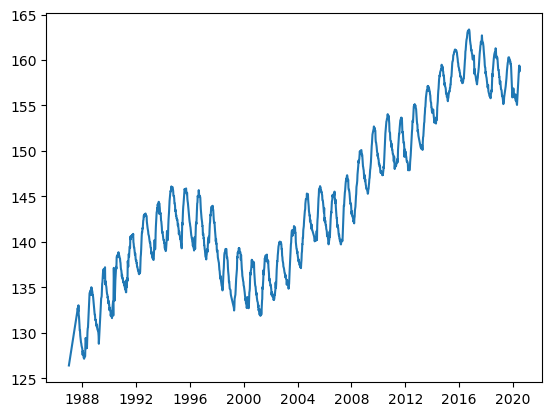

In [107]:
df_site = df_10[df_10.SITE_CODE == "384121N1212102W001"]

fig, ax = plt.subplots()
ax.plot(df_site.MSMT_DATE, df_site.GSE_WSE)

It's a basic plot but it works!

Let's improve the readability of this plot a bit. Can you see in the code below where each of these changes was made?

* Increase the resolution of the image (the default 100 dpi)
* Label each axis
* Label the entire figure

Text(0.5, 0.98, 'Site 384121N1212102W001 (Sacremento)')

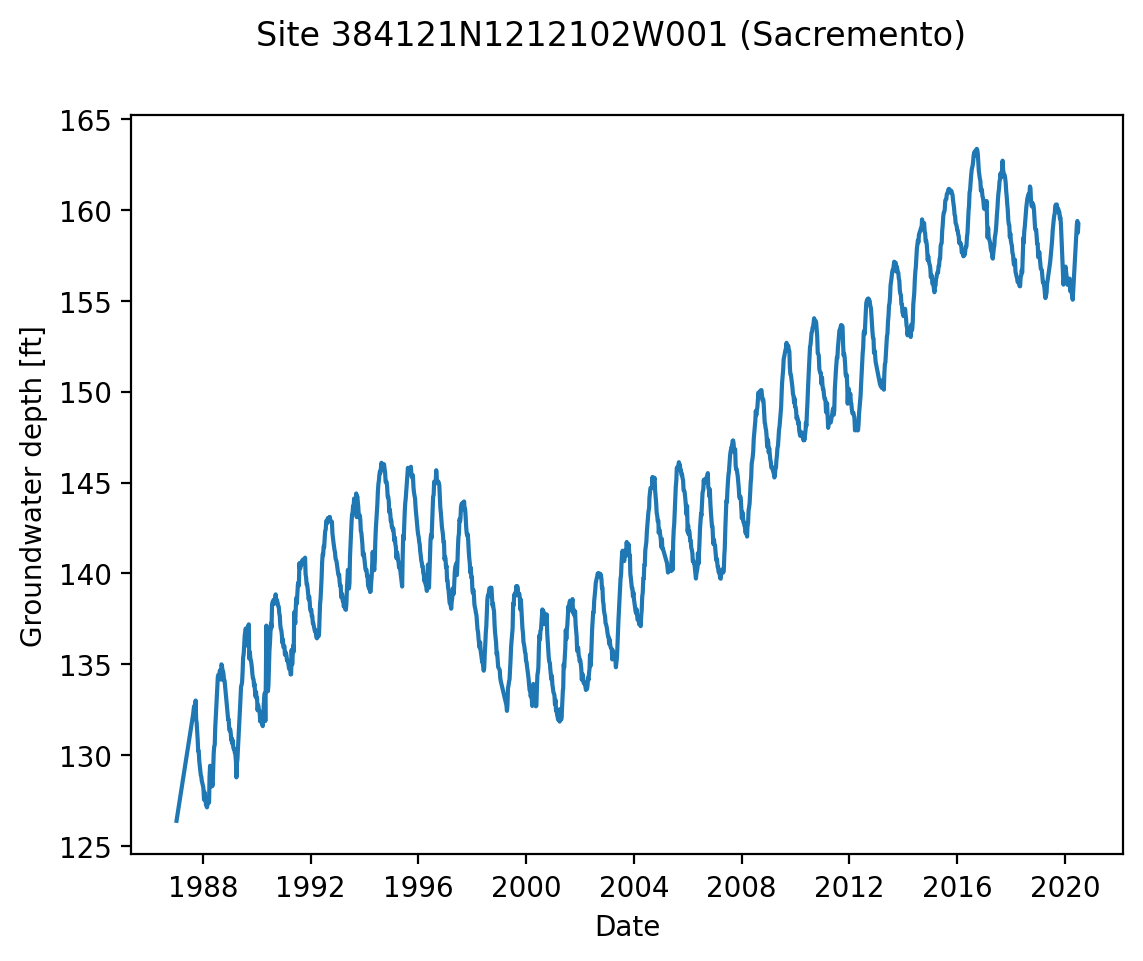

In [108]:
fig, ax = plt.subplots(dpi=200)
ax.plot(df_site.MSMT_DATE, df_site.GSE_WSE)
ax.set_xlabel("Date")
ax.set_ylabel("Groundwater depth [ft]")
fig.suptitle("Site 384121N1212102W001 (Sacremento)")

We can visualize the same data using a scatter plot, with 50% transparent markers to show the density of overlapping points

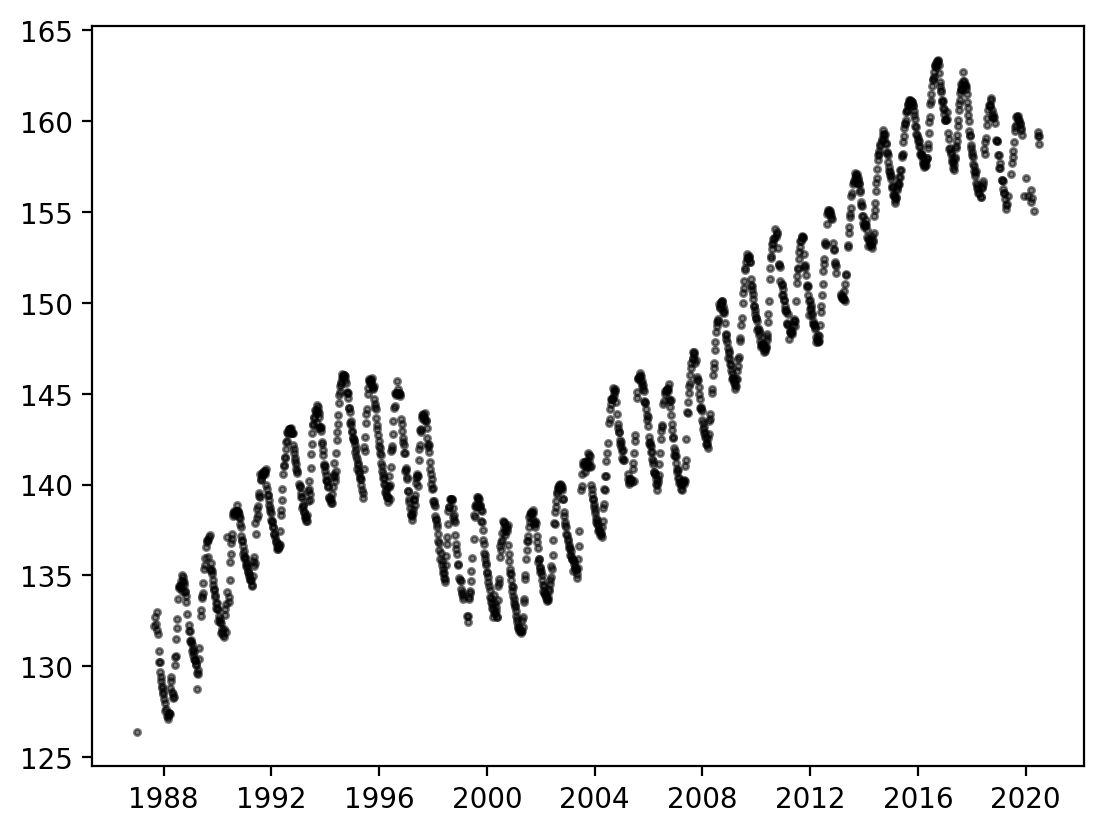

In [109]:
fig, ax = plt.subplots(dpi=200)
ax.scatter(
    df_site.MSMT_DATE,
    df_site.GSE_WSE,
    alpha=0.5,
    color="black",
    s=5,  # Marker size.
)

Multiple things can be plotted on the same Axes object. For example, it can be helpful to have both the interpolated line from `plot()` as well as the observation locations from `scatter()`. The most recent plot will be on top.

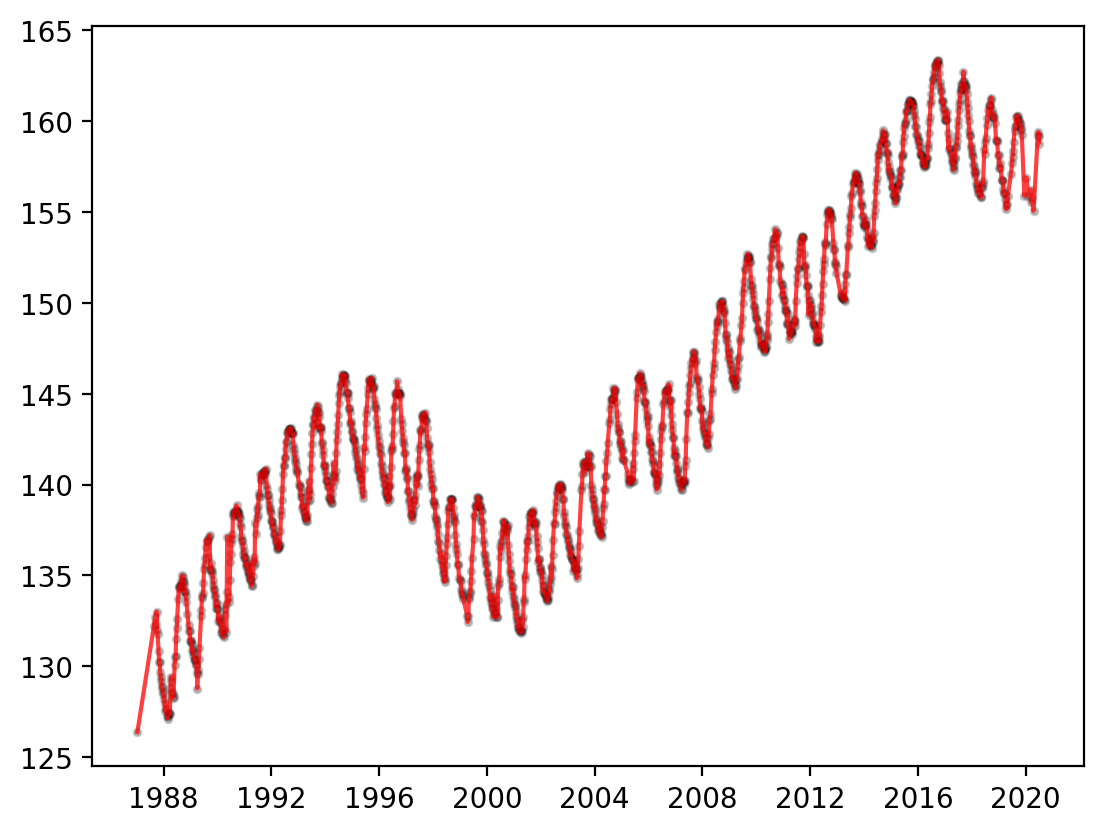

In [110]:
fig, ax = plt.subplots(dpi=200)
ax.scatter(
    df_site.MSMT_DATE,
    df_site.GSE_WSE,
    alpha=0.2,
    color="black",
    s=6,
)
ax.plot(df_site.MSMT_DATE, df_site.GSE_WSE, color="red", alpha=0.75)

Going back to our original dataset of 10 different stations, lets plot all 10 in a loop onto the same Axes object. To tell the lines apart, we add a `label=` argument to each `plot` call, then add a legend box to the axis with the `legend()` method

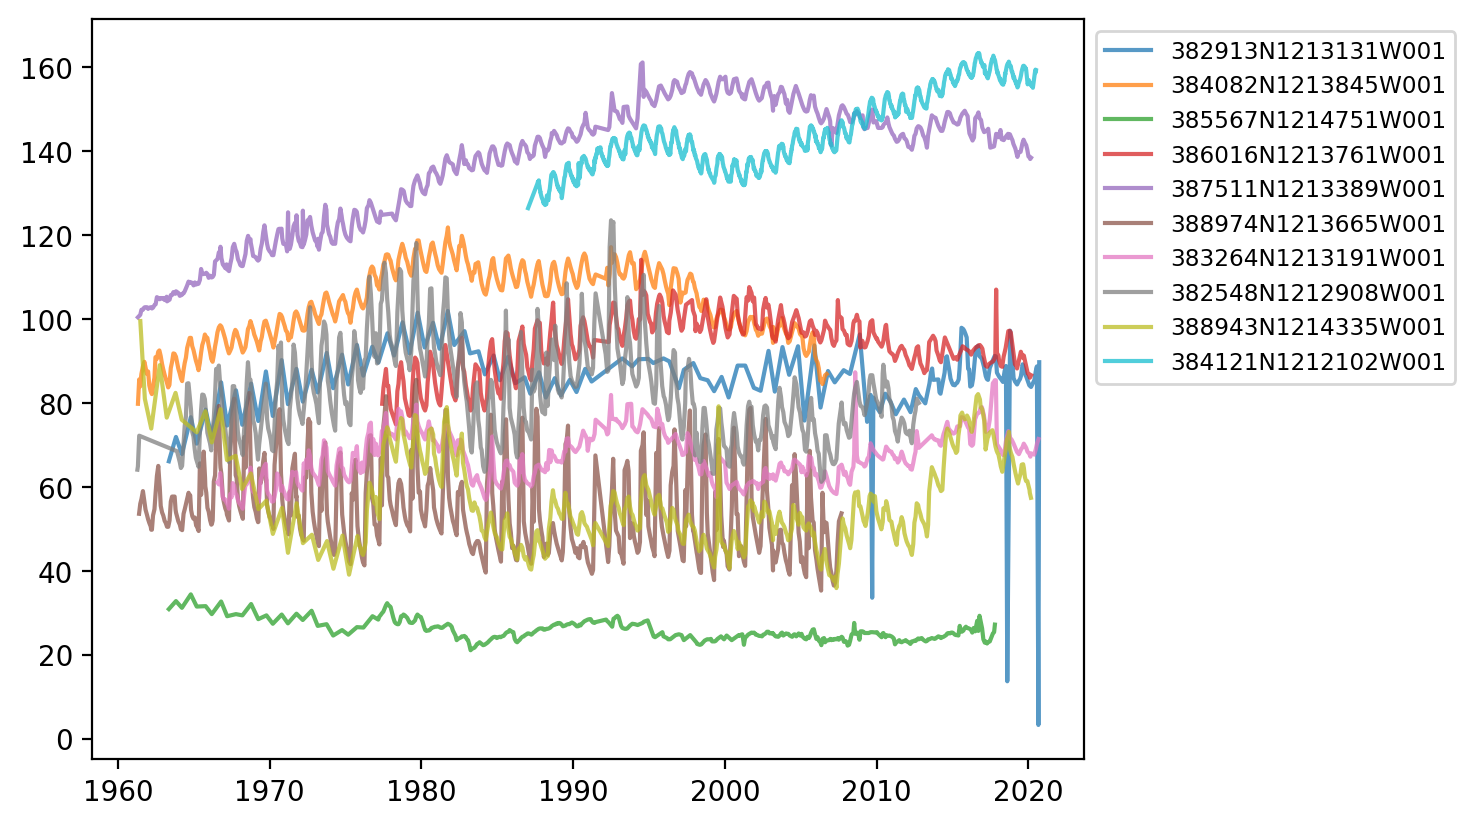

In [111]:
fig, ax = plt.subplots(dpi=200)

for site_code in df_10.SITE_CODE.unique():
    df_site_code = df_10[df_10.SITE_CODE == site_code]
    ax.plot(df_site_code.MSMT_DATE, df_site_code.GSE_WSE, alpha=0.75, label=site_code)
ax.legend(
    fontsize="small",
    bbox_to_anchor=(1, 1),  # Shift legend outside of plot.
)

### Saving plots

You can save a plot using the Figure's `savefig` method. For instance, to save a pdf version of the most recent plot

```python
fig.savefig("10-site-water-depth.pdf")
```

Even quicker in a noteook environment: right click on the plot, and copy/save as a PNG!



### Plotting with seaborn

With data that requires aggregation to plot, the seaborn package can handle much of the complexity for you.

Seaborn is normally imported with the `sns` abbreviation.


In [112]:
import seaborn as sns

Using seaborn with DataFrames is a little different than with matplotlib directly. You typically pass the whole DataFrame as a `data` argument, then the column names (rather than the data) as the `x` and `y` arguments.

Seaborn has it's own scatter function (`scatterplot`):

<Axes: xlabel='MSMT_DATE', ylabel='GSE_WSE'>

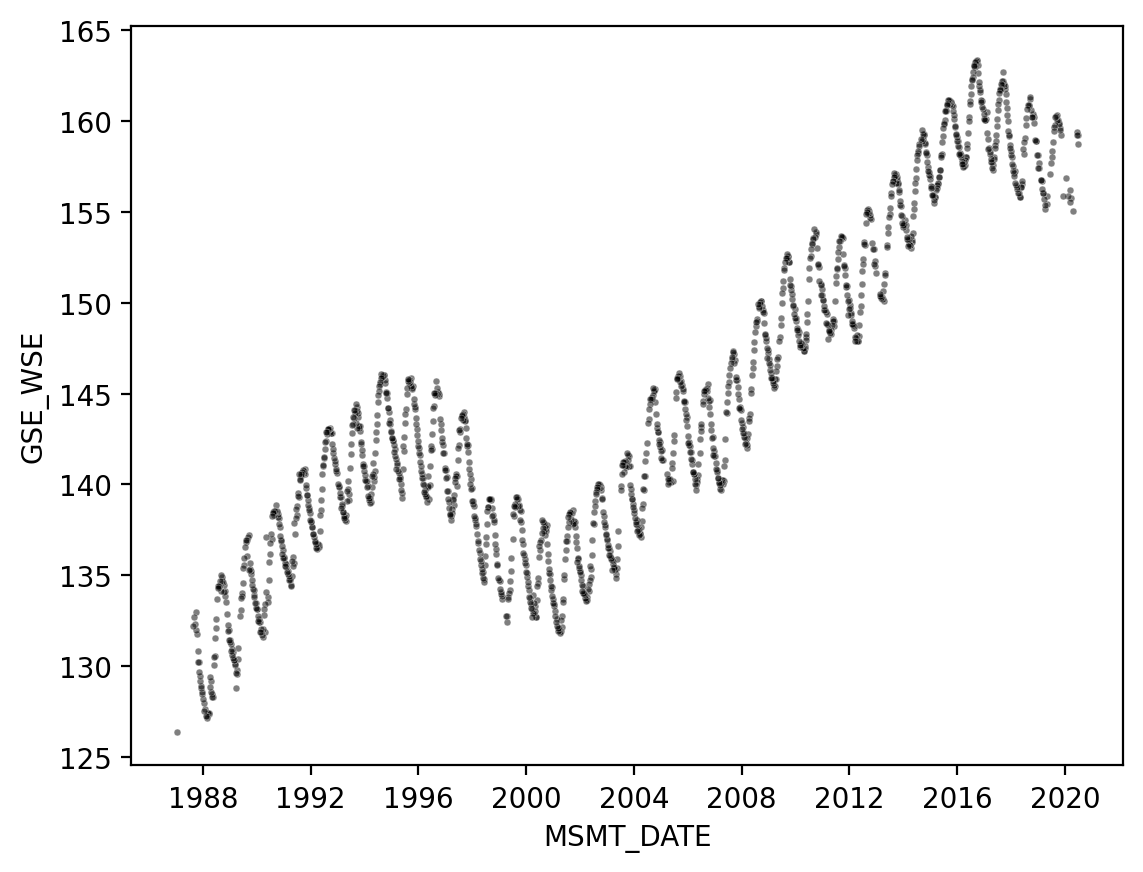

In [113]:
fig, ax = plt.subplots(dpi=200)
sns.scatterplot(
    ax=ax,
    data=df_site,
    x="MSMT_DATE",
    y="GSE_WSE",
    alpha=0.5,
    color="black",
    s=6,
)

With seaborn, we still use a matplotlib Figure and Axes. But we automatically get axis labels!

Most seaborn functions perform some data processing before plotting. For example, `histplot` calculates and plots a histogram

<Axes: xlabel='GSE_WSE', ylabel='Count'>

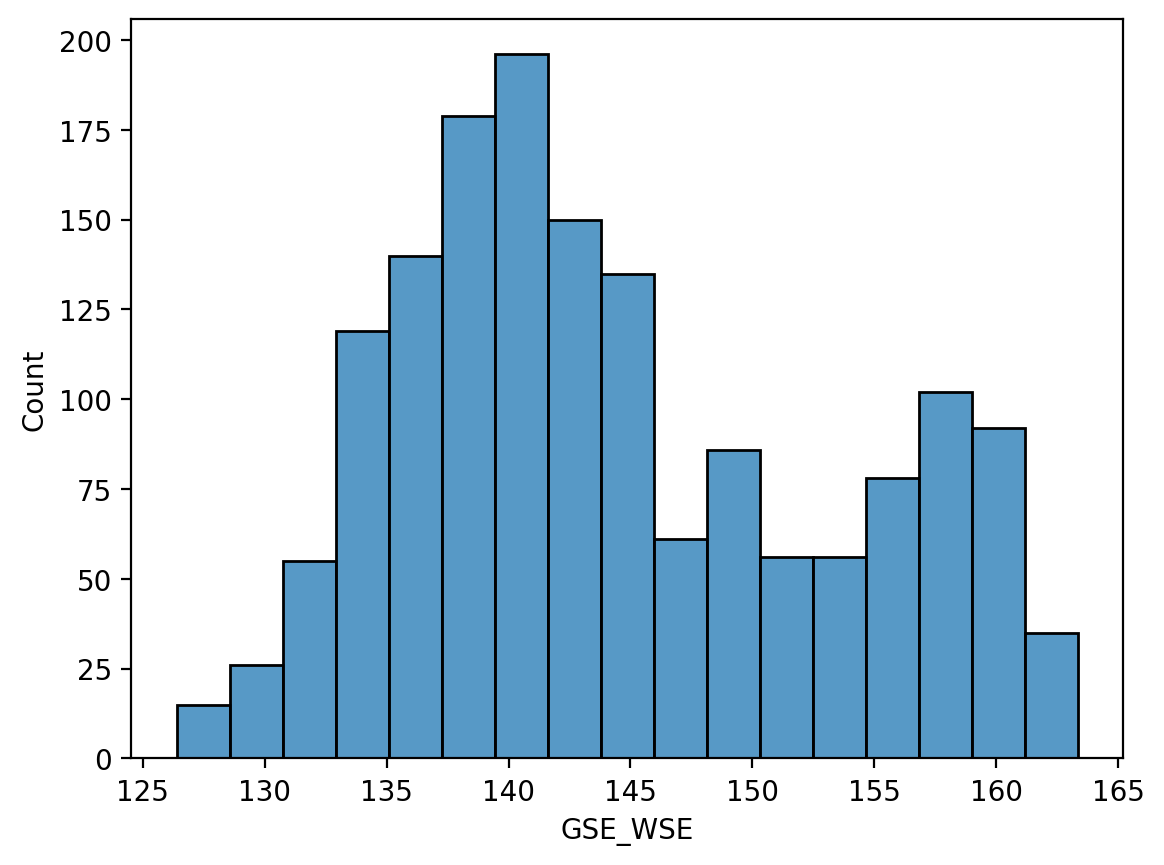

In [114]:
fig, ax = plt.subplots(dpi=200)
sns.histplot(ax=ax, data=df_site, x="GSE_WSE")


The thin lines of a KDE distribution plot (`kdeplot()`) make it easier to compare in the distribution of all 10 sites

<Axes: xlabel='GSE_WSE', ylabel='Density'>

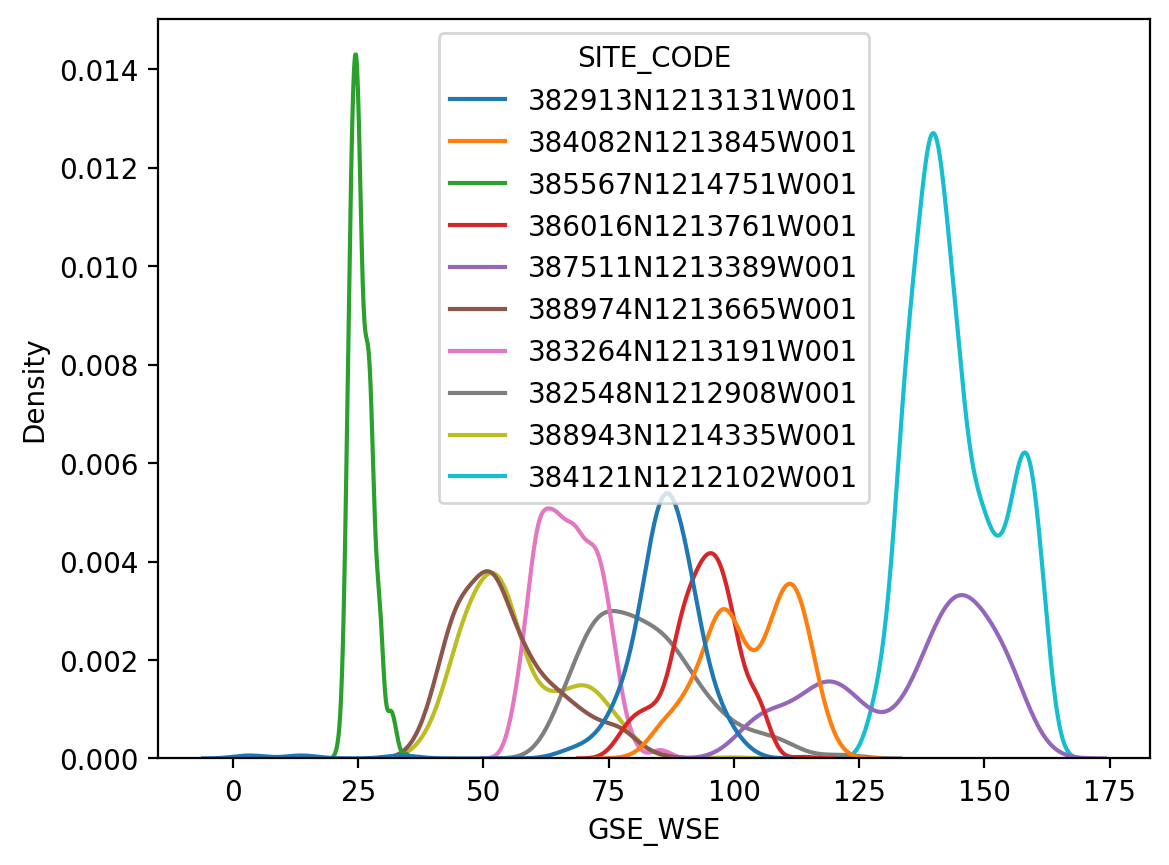

In [115]:
fig, ax = plt.subplots(dpi=200)

sns.kdeplot(ax=ax, data=df_10, x="GSE_WSE", hue="SITE_CODE")


It's still a little messy though, a box plot might be clearer still.

<Axes: xlabel='GSE_WSE', ylabel='SITE_CODE'>

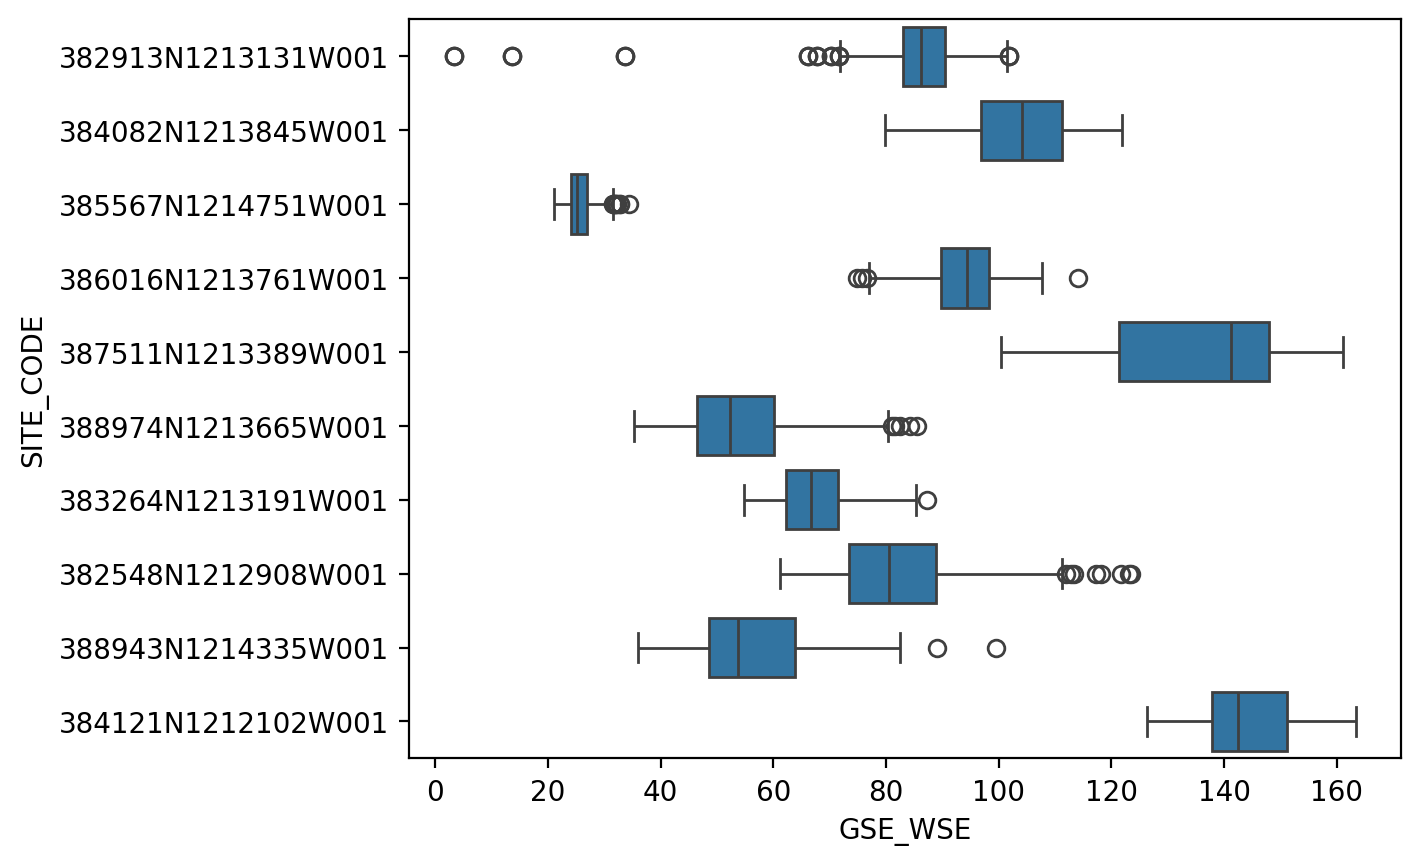

In [116]:
fig, ax = plt.subplots(dpi=200)
sns.boxplot(ax=ax, data=df_10, x="GSE_WSE", y="SITE_CODE")

Seaborn has dozens of plot functions, mostly invoking comparing distributions of data.

The [seaborn gallery](https://seaborn.pydata.org/examples/index.html) is the place to go for a good overview of what seaborn can do.